In [2]:
# Conductivity to PSU conversion, both UNESCO '83 and UNESCO '10
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig
import os

from itertools import groupby
import gsw

In [20]:
dataDirectory = '/Users/edwardlrichards/Documents/data/KAM11/enviornment/CTD/shipsCTD'
ctd_files = os.listdir(dataDirectory)
ctdData = None
lon = -159
lat = 22

# Filter used to detect upcast or downcast
N=512
Fc=0.001
Fs=1
h=sig.firwin(numtaps=N, cutoff=Fc, nyq=Fs/2)
castIndex = 0
for i, file in enumerate(ctd_files):
    
    fPath = os.path.join(dataDirectory, file)
    fileName, fileExtension = os.path.splitext(file)
    
    if fileExtension != '.cnv':
        continue
    with open(fPath) as f:
        for i, line in enumerate(f.readlines()):
            if line == '*END*\n':
                lineNumber = i
                break
                
    # CTD data from cast
    shipCTD = str(castIndex) + '_ctd'
    # T
    if file !='km1119_cast1SSPconv.cnv':
        data = pd.read_csv(fPath, skiprows=lineNumber+1, sep=r"\s+",\
                names=['db', 'S/m', 'PSU', 'C', shipCTD,\
                'm', 'blah'], index_col='m')
    else:
        data = pd.read_csv(fPath, skiprows=lineNumber+1, sep=r"\s+",\
                names=['db', 'S/m', 'PSU', 'C', shipCTD,\
                'avg m/s', 'm', 'blah'], index_col='m')
        del data['avg m/s']

    del data['blah']
    
    # downcast detection, upcasts were not recorded
    eps = 0.0004
    y=sig.lfilter(h, 1.0, data.index)
    yDiff = np.diff(y)
    diffI = np.arange(yDiff.size)

    # Group casts by sign of depth derivative
    blocks = [list(g) for k, g in groupby(list(yDiff>eps))]
    
    blockI = 0
    longestBlock = 0
    currentI = 0
    for i, b in enumerate(blocks):
        if b[0] & (longestBlock < len(b)):
            longestBlock = len(b)
            blockI = i
            startIndex = currentI
        currentI += len(b)

    data = data.iloc[startIndex:(startIndex+longestBlock), :]
    
    # calculate sound speed from gsw
    psuFromData = gsw.SP_from_C(10 * data['S/m'], data['C'], data['db'])
    abSal = gsw.SA_from_SP(data['PSU'], data['db'], lon, lat)
    conTemp = gsw.CT_from_t(abSal, data['C'], data['db'])
    gsw_SSP = gsw.sound_speed(abSal, conTemp, data['db'])

    break

In [21]:
# This seems to work well
np.max(np.abs(psuFromData - data['PSU']))

9.0379034816123749e-05

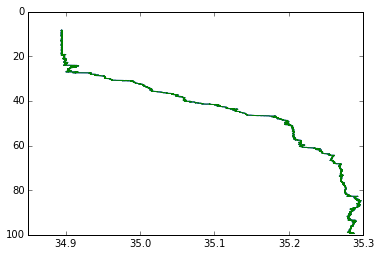

In [22]:
_ = plt.plot(psuFromData, data.index)
_ = plt.plot(data['PSU'], data.index)

_ = plt.ylim(100, 0)